In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg


plt.style.use('seaborn')
%matplotlib inline

In [2]:
np.random.seed(1)

# 1. Fitting Classification Trees

In [3]:
carseats = pd.read_csv('data/Carseats.csv')

In [4]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
carseats = carseats.assign(
    High = np.where(carseats['Sales'] <= 8, 0, 1),
    Urban = carseats['Urban'].map({'Yes': 1, 'No': 0}),
    US = carseats['US'].map({'Yes': 1, 'No': 0}),
    ShelveLoc = carseats['ShelveLoc'].map({'Bad': 0, 'Medium': 1, 'Good': 2})
)

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import graphviz

In [7]:
X = carseats.drop(columns=['High', 'Sales'])
y = carseats['High']

model = DecisionTreeClassifier(min_samples_leaf=5, random_state=42).fit(X, y)

In [8]:
model.feature_names_in_

array(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'], dtype=object)

In [9]:
model.feature_importances_

array([0.10622421, 0.09959502, 0.06878142, 0.04389278, 0.34249845,
       0.23602621, 0.09541704, 0.        , 0.        , 0.00756488])

In [10]:
model.score(X, y)

0.92

In [11]:
model.get_n_leaves()

38

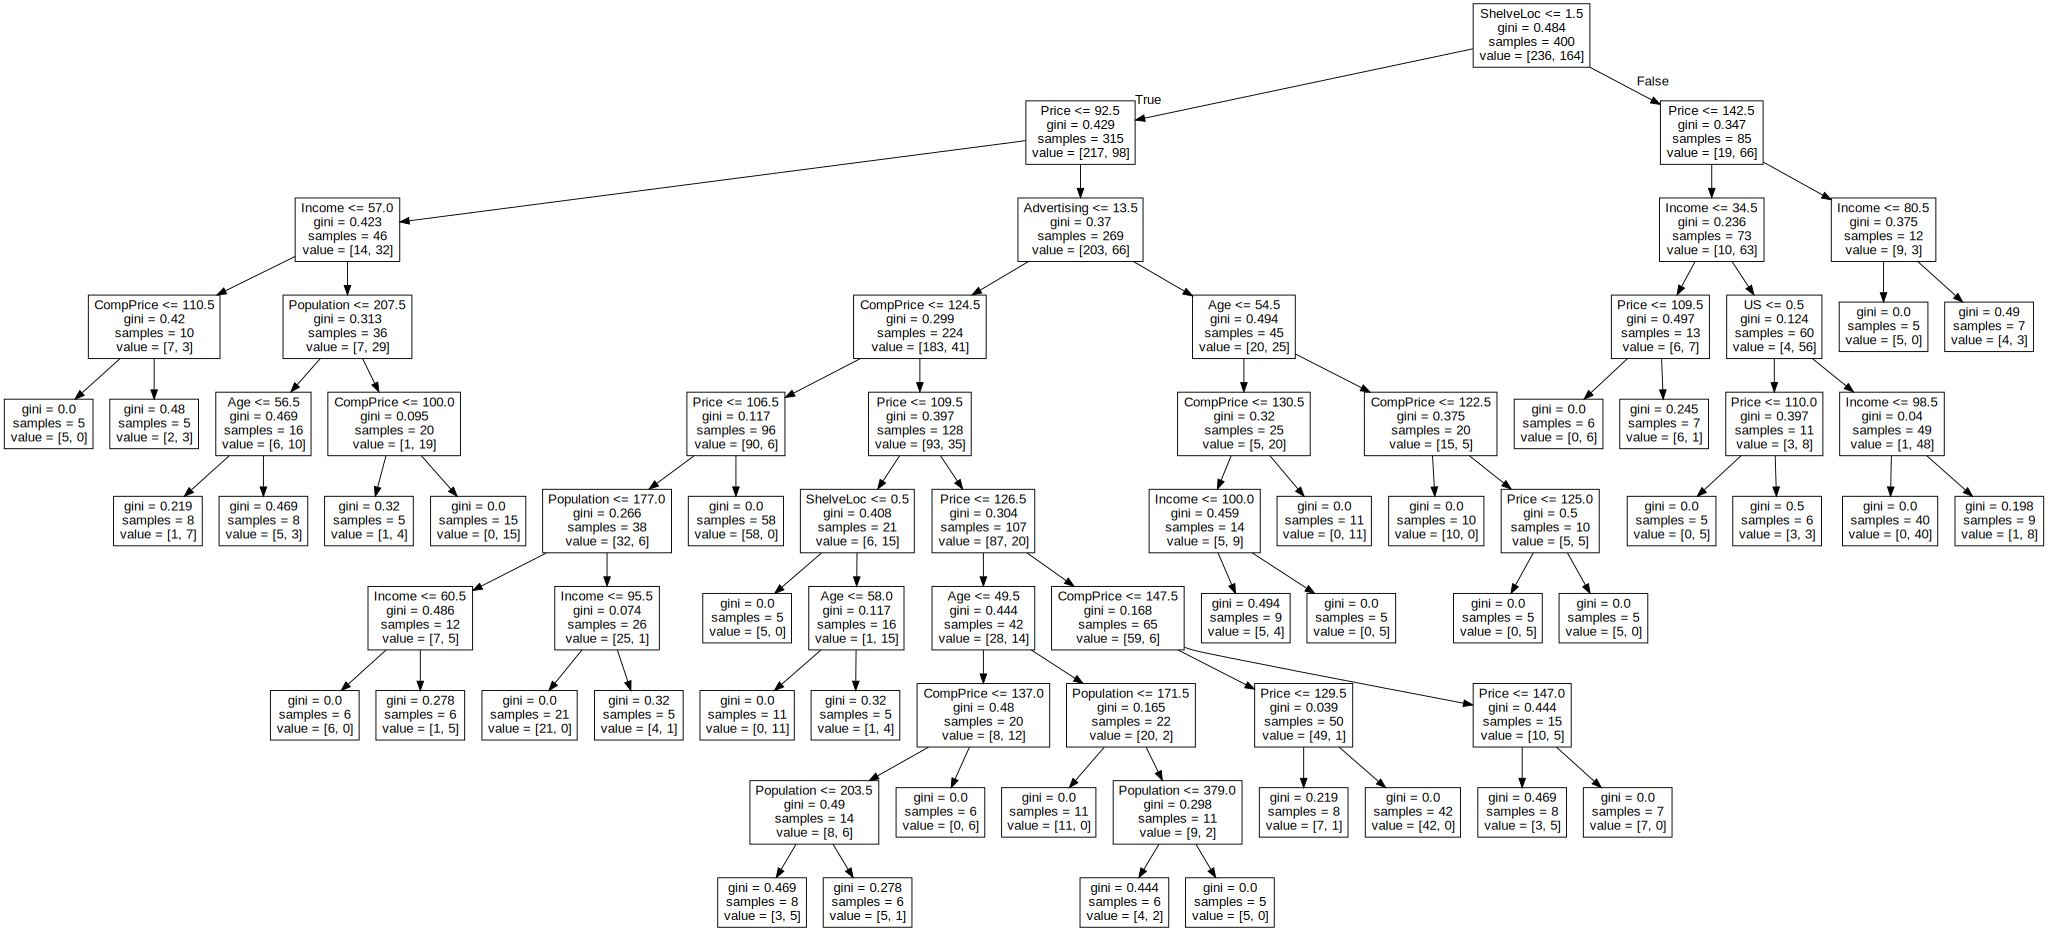

In [12]:
export_graphviz(model, out_file='tree.dot', feature_names=X.columns)

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2, train_size=0.5)

In [14]:
model = DecisionTreeClassifier(random_state=2).fit(X_train, y_train)

In [15]:
y_pred = model.predict(X_test)

In [16]:
confusion_matrix(y_test, y_pred)

array([[93, 33],
       [15, 59]], dtype=int64)

In [17]:
(93 + 59) / 200

0.76

In [18]:
clf = DecisionTreeClassifier(random_state=2)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

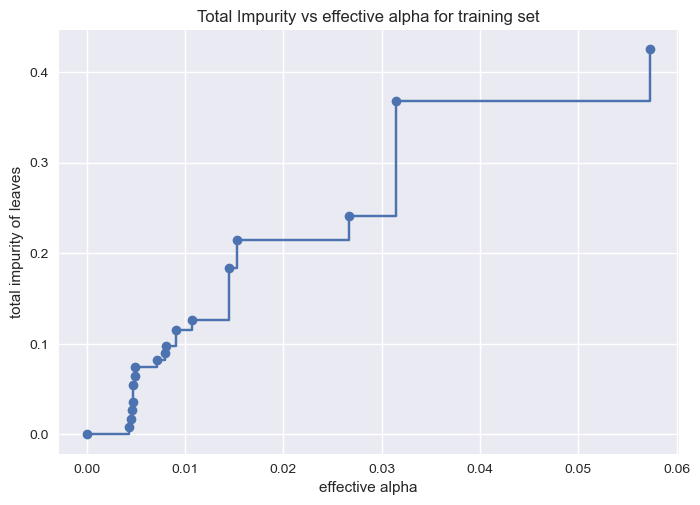

In [19]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07031250000000011


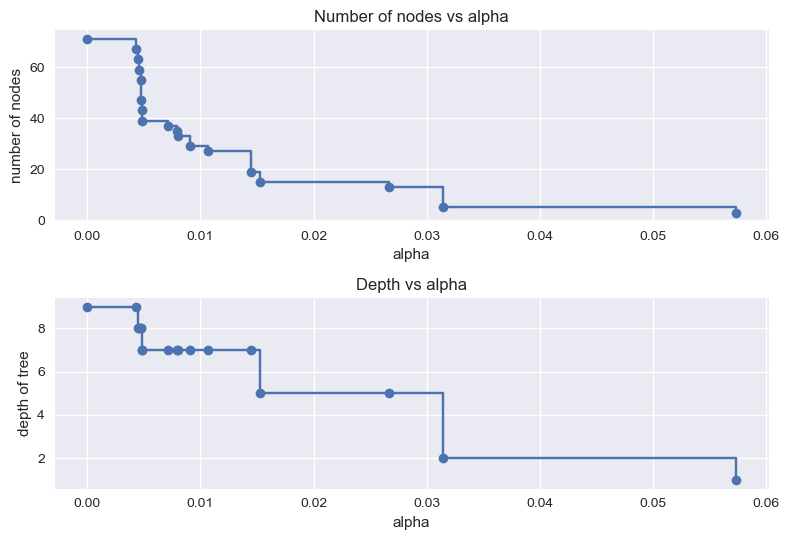

In [21]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

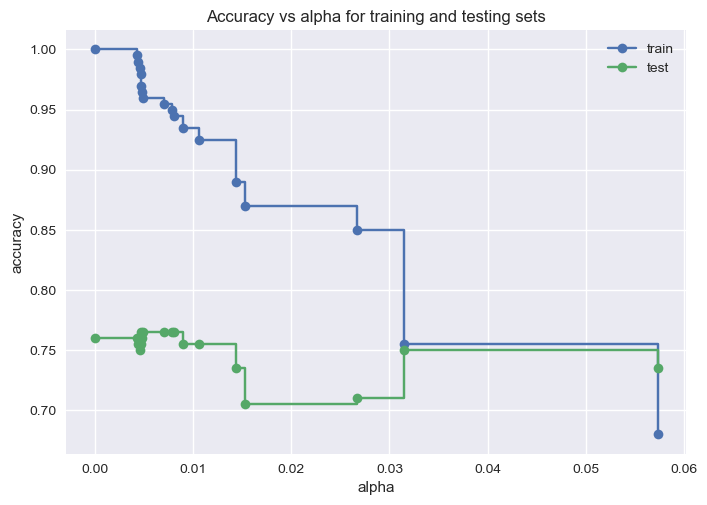

In [22]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

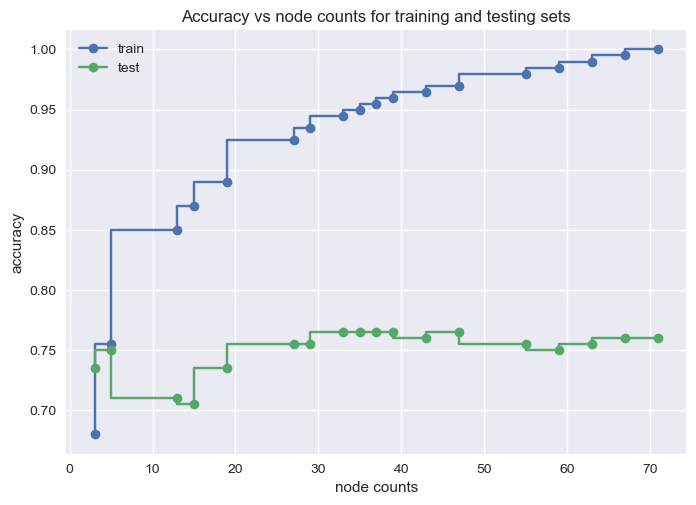

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("node counts")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs node counts for training and testing sets")
ax.plot(node_counts, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [24]:
train_scores_cv = [cross_val_score(DecisionTreeClassifier(
    random_state=2, ccp_alpha=ccp_alpha), X_train, y_train, cv=10).mean()
                   for ccp_alpha in ccp_alphas]

Text(0.5, 1.0, 'alpha vs accuracy')

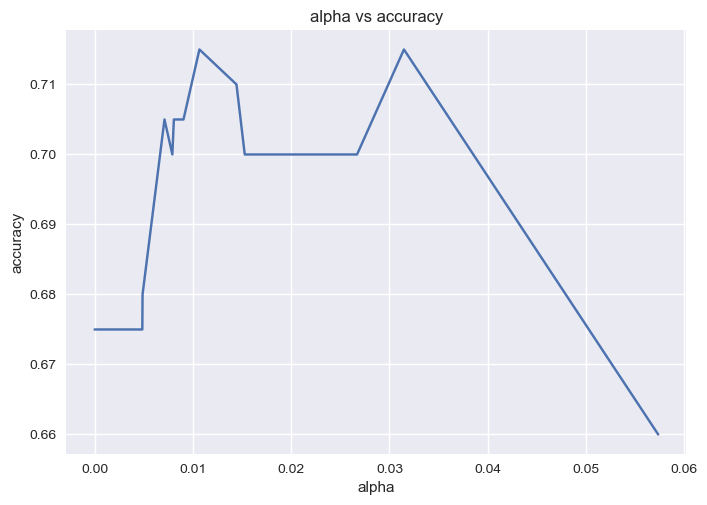

In [25]:
fig, ax = plt.subplots()

ax.plot(ccp_alphas, train_scores_cv)
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('alpha vs accuracy')

In [26]:
np.argsort(train_scores_cv)

array([17,  6,  5,  4,  0,  2,  1,  3,  7,  9, 15, 14, 10, 11,  8, 13, 12,
       16], dtype=int64)

In [27]:
model = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alphas[12]).fit(X_train, y_train)
model.score(X_test, y_test)

0.755

# 2. Fitting Regression Trees

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [29]:
boston = pd.read_csv('data/Boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [30]:
X = boston.drop(columns='medv')
y = boston['medv'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5)

In [31]:
tree = DecisionTreeRegressor(random_state=1, min_samples_leaf=5).fit(X_train, y_train)

In [32]:
tree.score(X_train, y_train)

0.9210012403522634

In [33]:
pd.DataFrame(
    {'Feature': tree.feature_names_in_, 
     'Importance': tree.feature_importances_})\
    .sort_values('Importance', ascending=False, ignore_index=True)

,Feature,Importance
0,lstat,0.618450
1,rm,0.247915
2,dis,0.061916
3,crim,0.036793
4,indus,0.009488
5,tax,0.008824
6,nox,0.006561
7,ptratio,0.006369
8,age,0.002468
9,chas,0.001217


In [34]:
tree.get_n_leaves()

41

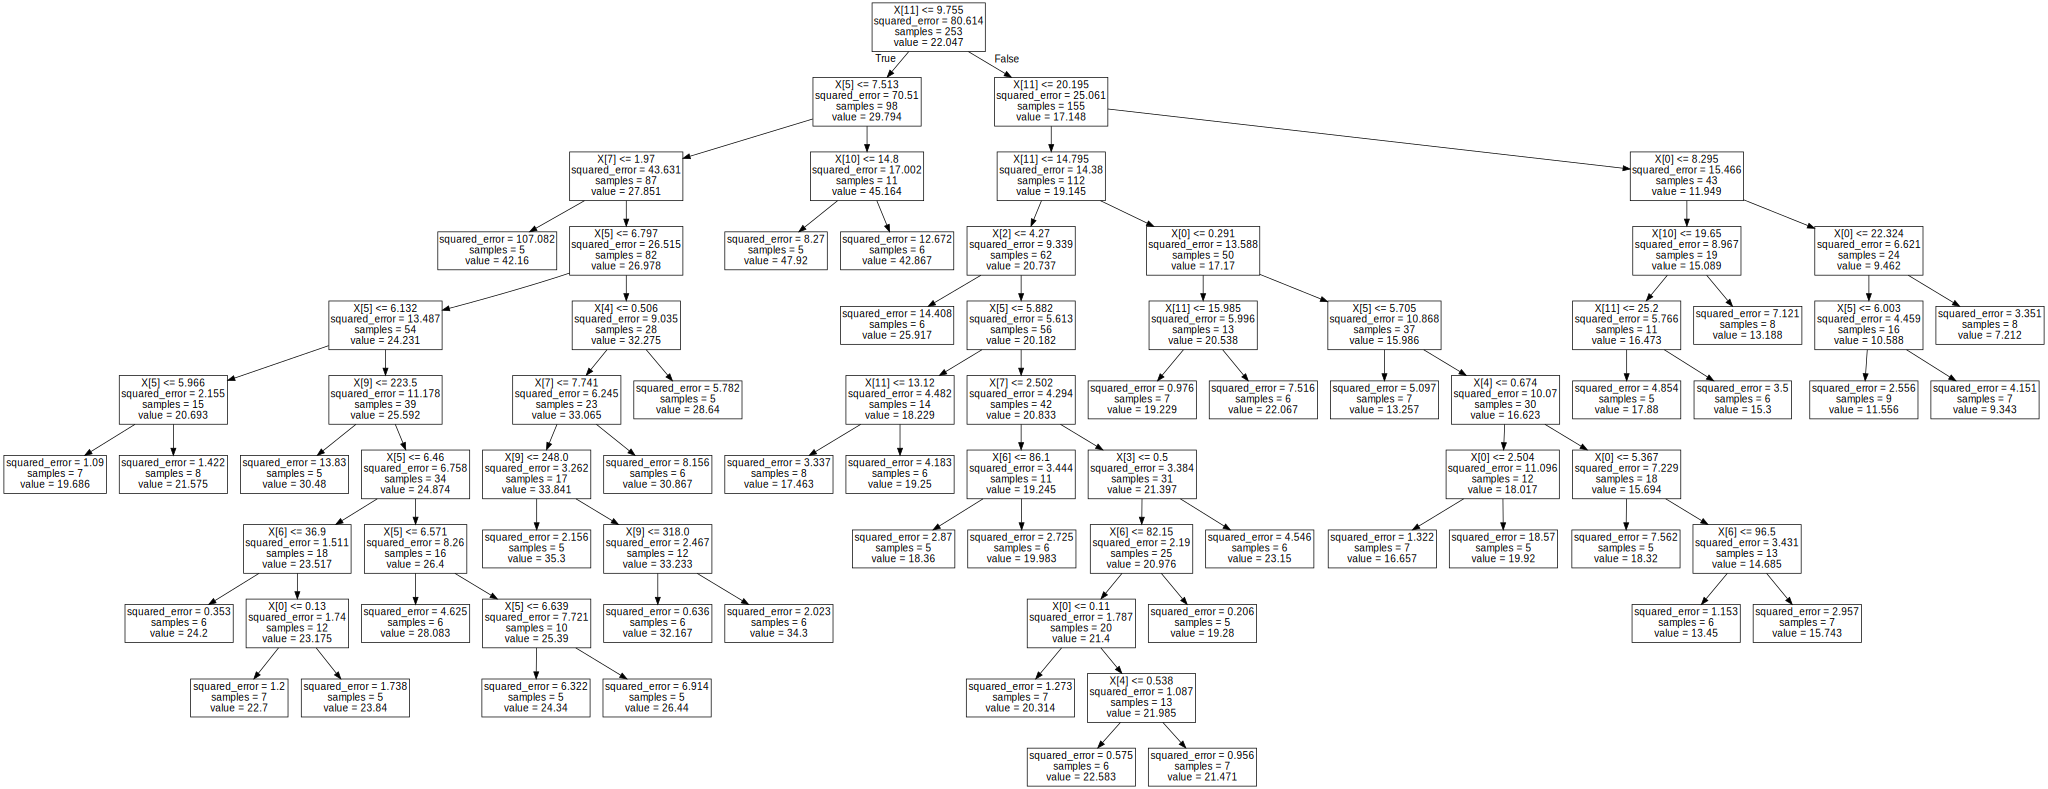

In [35]:
export_graphviz(tree, 'tree_clf.dot')

with open('tree_clf.dot') as f:
    content = f.read()
    
graphviz.Source(content)

In [36]:
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [37]:
ccp_alphas = ccp_alphas[:-1]

trees = [
    DecisionTreeRegressor(
        random_state=1, ccp_alpha=ccp_alpha, min_samples_split=5)
    for ccp_alpha in ccp_alphas
]

In [38]:
train_scores_cv = [cross_val_score(tree, X_train, y_train, cv=10).mean()
                   for tree in trees]

[Text(0.5, 0, 'alpha'), Text(0, 0.5, 'R^2')]

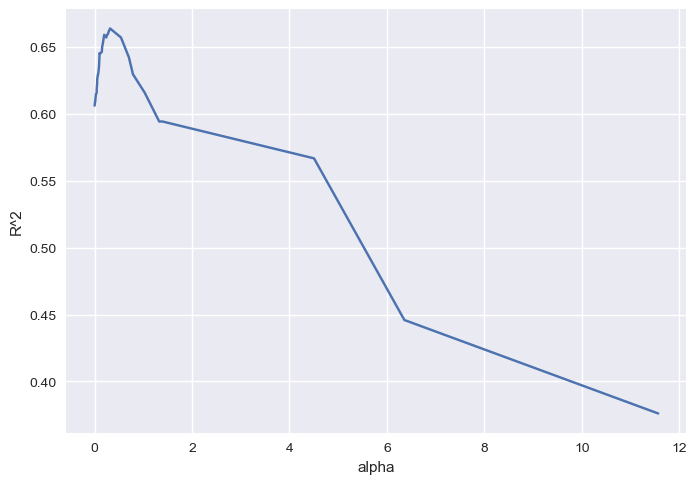

In [39]:
fig, ax = plt.subplots()

ax.plot(ccp_alphas, train_scores_cv)
ax.set(xlabel='alpha', ylabel='R^2')

In [40]:
tree_pruned = trees[np.argmax(train_scores_cv)].fit(X_train, y_train)

Text(0, 0.5, 'Predicted values')

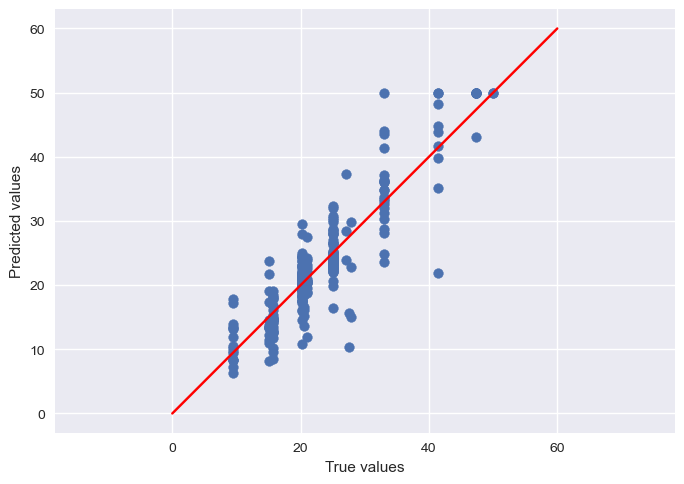

In [41]:
y_pred = tree_pruned.predict(X_test)

plt.scatter(y_pred, y_test)
plt.axis('equal')
plt.plot([0, 60], [0, 60], c='red')
plt.xlabel('True values')
plt.ylabel('Predicted values')

In [42]:
mean_squared_error(y_test, y_pred)

17.18671888978747

# 3. Bagging and Random Forests

In [43]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [44]:
bag_boston = BaggingRegressor(random_state=1, max_features=12)\
    .fit(X_train, y_train)

Text(0, 0.5, 'Predicted values')

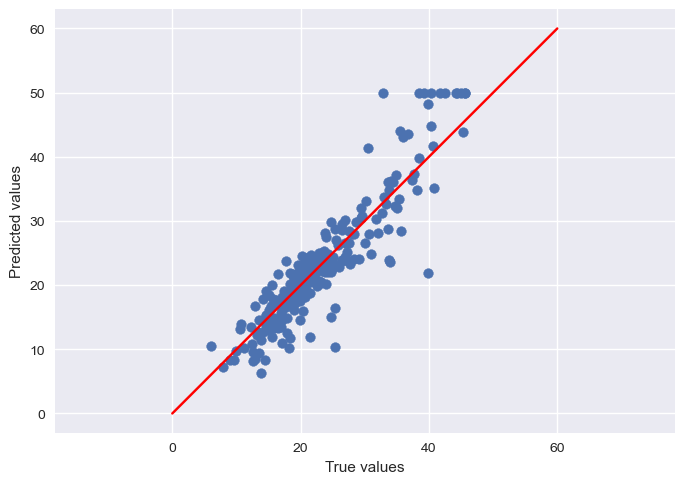

In [45]:
y_pred = bag_boston.predict(X_test)

plt.scatter(y_pred, y_test)
plt.axis('equal')
plt.plot([0, 60], [0, 60], c='red')
plt.xlabel('True values')
plt.ylabel('Predicted values')

In [46]:
mean_squared_error(y_test, y_pred)

14.865199604743081

In [47]:
bag_boston = BaggingRegressor(n_estimators=25 ,random_state=1, max_features=12)\
    .fit(X_train, y_train)
y_pred = bag_boston.predict(X_test)
mean_squared_error(y_test, y_pred)

12.9790663083004

In [48]:
rf_boston = RandomForestRegressor(random_state=1, max_features=6)\
    .fit(X_train, y_train)
y_pred = bag_boston.predict(X_test)
mean_squared_error(y_test, y_pred)

12.9790663083004

In [49]:
importances = pd.DataFrame(
    {'Feature': rf_boston.feature_names_in_, 
     'Importance': rf_boston.feature_importances_})\
    .sort_values('Importance', ascending=False, ignore_index=True)

importances

,Feature,Importance
0,lstat,0.424378
1,rm,0.275429
2,dis,0.060684
3,crim,0.055730
4,nox,0.046824
5,indus,0.043465
6,age,0.033198
7,ptratio,0.030109
8,tax,0.017286
9,rad,0.007616


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

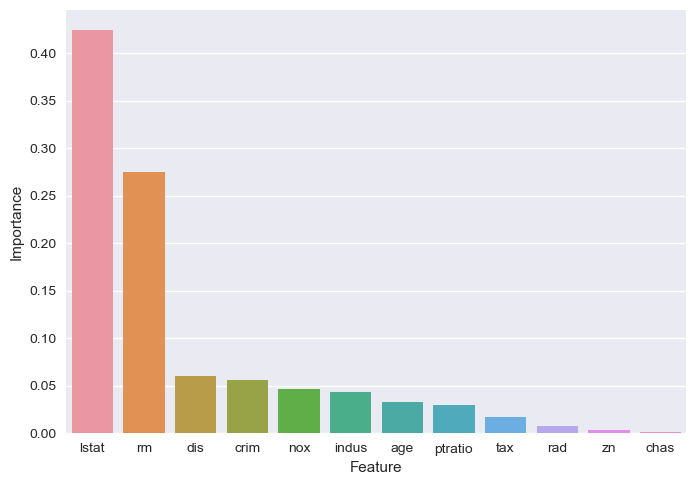

In [50]:
sns.barplot(data=importances, x='Feature', y='Importance')

# 4. Boosting

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
boston_boost = GradientBoostingRegressor(n_estimators=5000, max_depth=4, 
                                         random_state=1, learning_rate=0.001)
boston_boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=4, n_estimators=5000,
                          random_state=1)

In [53]:
importances = pd.DataFrame(
    {'Feature': boston_boost.feature_names_in_, 
     'Importance': boston_boost.feature_importances_})\
    .sort_values('Importance', ascending=False, ignore_index=True)

importances

,Feature,Importance
0,lstat,0.594702
1,rm,0.219616
2,dis,0.085745
3,crim,0.027941
4,ptratio,0.017237
5,tax,0.016780
6,nox,0.015234
7,age,0.012567
8,indus,0.006493
9,rad,0.002440


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

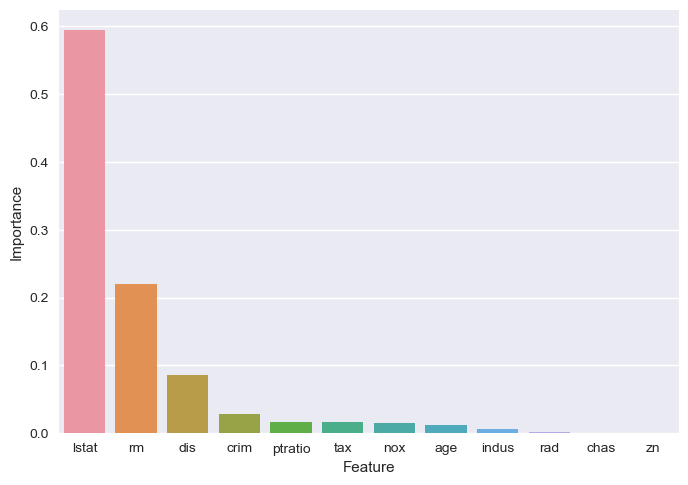

In [54]:
sns.barplot(x='Feature', y='Importance', data=importances)

In [55]:
mean_squared_error(y_test, boston_boost.predict(X_test))

11.155296757414119

In [56]:
boston_boost2 = GradientBoostingRegressor(n_estimators=5000, max_depth=4, 
                                         random_state=1, learning_rate=0.2)
boston_boost2.fit(X_train, y_train)
mean_squared_error(y_test, boston_boost2.predict(X_test))

11.623841881840127

# 5. Bayesian Additive Regression Trees

__No implementation in Python yet__